# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score #plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Loading Dataset

In [4]:
sheet_name = 'Complete_case'
df = pd.read_excel('01_datasets.xlsx',sheet_name=sheet_name)
df.head()

,age,blood pressure,specific gravity,albumin,Sugar,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,Blood Urea,Serum Creatinine,Hemoglobin,Packed Cell Volume,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,80,1.020,1,0,normal,notpresent,notpresent,121,36.0,1.2,15.4,44,yes,yes,no,good,no,no,ckd
1,62,80,1.010,2,3,normal,notpresent,notpresent,423,53.0,1.8,9.6,31,no,yes,no,poor,no,yes,ckd
2,48,70,1.005,4,0,abnormal,present,notpresent,117,56.0,3.8,11.2,32,yes,no,no,poor,yes,yes,ckd
3,51,80,1.010,2,0,normal,notpresent,notpresent,106,26.0,1.4,11.6,35,no,no,no,good,no,no,ckd
4,68,70,1.010,0,0,normal,notpresent,notpresent,100,54.0,24.0,12.4,36,no,no,no,good,no,no,ckd


# Exploratory Data Analysis

### Looking at the class distribution

<Axes: xlabel='Class ', ylabel='count'>

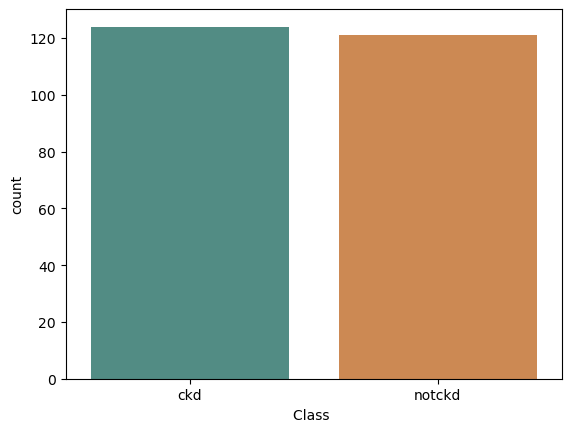

In [7]:
sns.countplot(data = df, x = 'Class ', palette = ['#49958B', '#E0873F'])

### Count plot of Appetite with hue as Class

<Axes: xlabel='Appetite', ylabel='count'>

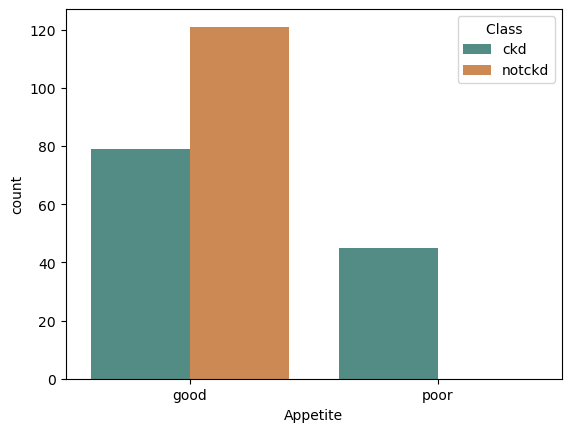

In [8]:
sns.countplot(data = df, x = 'Appetite', hue = 'Class ', palette = ['#49958B', '#E0873F'])